In [425]:
import numpy as np
from queue import PriorityQueue
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# matrice de similarité
S = np.array([      [10, 6, 0, 0, 0, 0, 0, 0, 0],
                    [6, 10, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 10, 5, 3, 3, 1, 1, 0],
                    [0, 0, 5, 10, 1, 2, 1, 1, 0],
                    [0, 0, 3, 1, 10, 4, 1, 2, 0],
                    [0, 0, 3, 2, 4, 10, 1, 4, 0],
                    [0, 0, 1, 1, 1, 1, 10, 1, 0],
                    [0, 0, 1, 1, 2, 4, 1, 10, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 10]])
N = S.shape[0]

In [426]:
#                                                   #
#           Fonction d'affichage faite par          #
#                   Elsa Bernet                     #
#                                                   #

#Utilisation de S, sinon décommenter "Autre méthode"
def creer_mat_link(fusions):
    #retourne Z:
    #1ERE COL = 1ere classe à fusionner
    #2IEME COL = 2nde classe à fusionner
    #3IEME COL = distance (on prendra 10-similarité car pas axe commence obligatoirement à 0)
    #4IEME COL = somme totale des classes fusionnées

    Z = np.zeros((N-1,4))
    ######Autre méthode similar = np.copy(sim_mat)
    ######Autre méthode I = np.ones(N)

    nb_cl = N-1
    nouv_cl = [[i, 1] for i in range(N)]
    
    for i in range(len(fusions)):
        ##1ere et 2ieme

        cl_fus1 = fusions[i][0]
        cl_fus2 = fusions[i][1]

        #On pourrait aussi faire en sorte que la classe la "plus petite" soit dans la 1ere colonne
        #et cela donnerait un dendrogramme similaire à celui rendu par dendrogram(sim_mat,method='single')
        #Cette méthode permet d'avoir les classes rangées dans l'ordre croissant comme vu en cours
        Z[i][0] = nouv_cl[cl_fus1][0] if nouv_cl[cl_fus1][0] != cl_fus1 else cl_fus1
        Z[i][1] = nouv_cl[cl_fus2][0] if nouv_cl[cl_fus2][0] != cl_fus2 else cl_fus2

        ##3ieme
        #Utilise la distance donc comme je n'arrive pa sà avoir un axe inversé je prend 10 (max sim)- similarité entre classes
        ######Autre méthode Z[i][2] = 10-similar[cl_fus1][cl_fus2]
        Z[i][2] = 10-S[cl_fus1][cl_fus2]
        #Pour différencier vu que la similarité est parfois identique. -0.1 pour que les couleurs restes différentes et qu'on puisse "mieux" voir
        if (Z[i][2] == Z[i-1][2]):
            Z[i-1][2] -= 0.1

        ##4ieme
        nb_cl += 1
        nouv_cl[cl_fus1][0] = nb_cl
        nouv_cl[cl_fus1][1] = nouv_cl[cl_fus1][1] + nouv_cl[cl_fus2][1]

        Z[i][3] = nouv_cl[cl_fus1][1]

        ######Autre méthode Méthode du lien unique pour recalculer la matrice et avoir la bonne similarité
        ######Autre méthode I[cl_fus2] = 0
        ######Autre méthode for j in range(N):
        ######Autre méthode     if (I[j]==1 and j != cl_fus1 and j!= cl_fus2):
        ######Autre méthode         similar[j][cl_fus1] = max(similar[j][cl_fus1], similar[j][cl_fus2])
        ######Autre méthode         similar[cl_fus1][j] = max(similar[j][cl_fus1], similar[j][cl_fus2])
    return Z

# Première implémentation de l'algorithme de clustering hiérarchique agglomératif

In [427]:
# génération du tableau de file de priorité sans les valeurs de la diagonale
def generate_priority_queue(sim_mat): # O(N²)
    P = []
    for i in range(N):
        P.append(PriorityQueue())
    for i in range(N):
        for j in range(N):
            if i != j:
                P[i].put((-sim_mat[i][j], j)) # on met les valeurs de la matrice de similarité dans la file de priorité en négatif pour avoir une file de priorité qui trie les valeurs par ordre croissant (spécificité de la file de priorité de PriorityQueue)
    return P

# implémentation de l'algorithme de clustering hiérarchique agglomératif
def clustering_hierarchique_agglomeratif(sim_mat): # O(N³)
    
    # initialisation de la liste des classes actives
    I = [1 for _ in range(N)]

    # initialisation du dendrogramme comme un ndarray de taille N-1
    dendrogramme = [[0, 0] for _ in range(N - 1)]

    # initialisation du tableau de file de priorité
    P = generate_priority_queue(sim_mat)
    temp_queue = PriorityQueue()
    # pour chaque itération k ∈ {1, ..., N − 1} faire
    for k in range(N - 1): # O(N-1)
        # a = argmax P[i].MAX.sim ; avec i ∈ {1, . . . , N} et I[i] = 1 ;
        a = 0
        max_sim = 1
        for i in range(N):  # O(N)
            if I[i] == 1 and P[i].queue[0][0] < max_sim:  # si la classe i est active et si la classe i est plus proche de la classe a que la classe a ne l'est d'elle-même
                max_sim = P[i].queue[0][0]
                a = i
        # b = P[a].MAX.index ;
        b = P[a].queue[0][1]
        
        dendrogramme[k][0] = a
        dendrogramme[k][1] = b
        
        # I[b] = 0 ;
        I[b] = 0

        # supprimer S[a][b] de P[a] ;
        P[a].get()

        for i in range(N):          # O(N)
            if I[i] == 1 and i != a:
                # supprimer S[i][a] de P[i] ;
                for j in range(P[i].qsize()): # O(N) 
                    if P[i].queue[0][1] != a and P[i].queue[0][1] != b:
                        temp_queue.put(P[i].queue[0])
                    P[i].get()
                # remettre les valeurs dans la file de priorité
                for j in range(temp_queue.qsize()): # O(N) 
                    P[i].put(temp_queue.queue[0])
                    temp_queue.get()

                # supprimer S[a][i] de P[a] ;
                for j in range(P[a].qsize()): # O(N) 
                    if P[a].queue[0][1] != i:
                        temp_queue.put(P[a].queue[0])
                    P[a].get()
                # remettre les valeurs dans la file de priorité
                for j in range(temp_queue.qsize()): # O(N) 
                    P[a].put(temp_queue.queue[0])
                    temp_queue.get()

                # S[i][a] ← max{S[i][a], S[i][b]} ; # Méthode du lien unique
                sia = max(sim_mat[i][a], sim_mat[i][b])

                # insérer (avec tri) S[i][a] dans P[i] et S[a][i] dans P[a] ;
                P[i].put((-sia, a))
                P[a].put((-sia, i))
    print(dendrogramme)
    matrix_link = creer_mat_link(dendrogramme.copy())
    dendrogram(matrix_link, orientation='top')
    return dendrogramme

# Deuxième implémentation de l'algorithme de clustering hiérarchique agglomératif

In [428]:
# on degage les valeur de la diagonale
def suppr_diagonale (sim_mat): # O(N²)
    N = sim_mat.shape[0]
    P = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                P[i][j] = sim_mat[i][j]
    return P

# fonction qui retourne un tableau de la forme [P[i].sim, P[i].index]
def tab_des_max_val(sim_mat): # O(N)
    N = sim_mat.shape[0]
    tab = []
    for i in range(N):
        tab.append([max(sim_mat[i]), sim_mat[i].argmax()])
    return tab

def clustering_hierarchique_agglomeratif2(sim_mat): # O(N²)
    P = suppr_diagonale(sim_mat) # fonction qui supprime la diagonale de la matrice de similarité
    P = tab_des_max_val(P) # fonction qui retourne un tableau de la forme P = [P[i].sim, P[i].index]
    
    I = [i for i in range(N)]
    dendrogramme = [[0, 0] for _ in range(N - 1)]
    
    for k in range(N - 1): # O(N-1)
        a = 0
        maxi = 0
        # a = argmax de P[i][0] quand i:I[i]=i
        for i in range(N): # O(N)
            if I[i] == i and P[i][0] > maxi:
                maxi = P[i][0]
                a = i
        b = I[P[a][1]]
        P[a][0] = -1
        dendrogramme[k][0] = a
        dendrogramme[k][1] = b
        for i in range(N): # O(N)
            if I[i] == i and i != a and i != b:
                sim_mat[i][a] = max(sim_mat[i][a], sim_mat[i][b])
                sim_mat[a][i] = max(sim_mat[i][a], sim_mat[i][b])
            if I[i] == b:
                I[i] = a
            if I[i] == i and i != a and sim_mat[a][i] > P[a][0]:
                P[a][0] = sim_mat[a][i]
                P[a][1] = i
    print(dendrogramme)
    matrix_link = creer_mat_link(dendrogramme)
    dendrogram(matrix_link, orientation='top')
    return dendrogramme

# Comparaison des deux implémentations

[[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 6], [0, 2], [0, 8]]


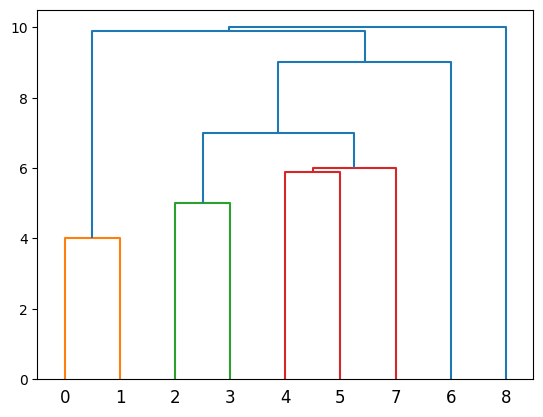

In [429]:
dendrogramme2 = clustering_hierarchique_agglomeratif2(S)

[[0, 1], [2, 3], [4, 5], [4, 7], [2, 4], [2, 6], [0, 2], [0, 8]]


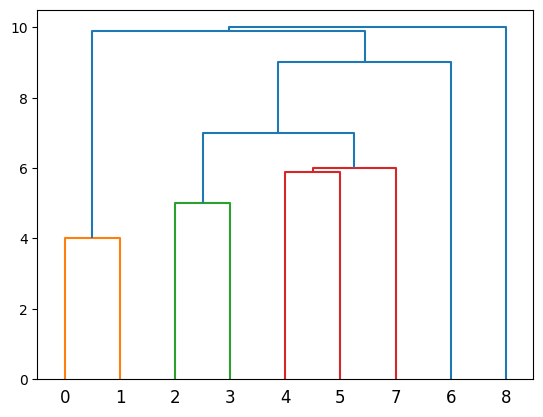

In [430]:
dendrogramme1 = clustering_hierarchique_agglomeratif(S)

# Remarque :
### On remarque que les deux dendrogrammes sont identiques, ce qui signifie que notre implémentation de l'algorithme de clustering hiérarchique agglomératif donne les memes résultats.

In [431]:
def compare_dendrogramme(dendrogramme1, dendrogramme2): # Verification que les deux dendrogrammes sont identiques
    N = len(dendrogramme1)
    for i in range(N):
        if dendrogramme1[i][0] != dendrogramme2[i][0] or dendrogramme1[i][1] != dendrogramme2[i][1]:
            return False
    return True

print(compare_dendrogramme(dendrogramme1, dendrogramme2))

True


# Remarque :
### Beaucoup d'optimisation peuvent etre ajouter au code pour empécher d'avoir à faire N fois la verification de la condition I[i] == 1. On sait simplement que l'on a un nombre de classes actives qui diminue à chaque itération. On peut donc stocker le nombre de classes actives dans une variable et un tableau des indexs des classes activent. On supprime l'index de la classe qui a été fusionné et on décrémente le nombre de classes actives.

# Comparaison avec la fonction de scipy

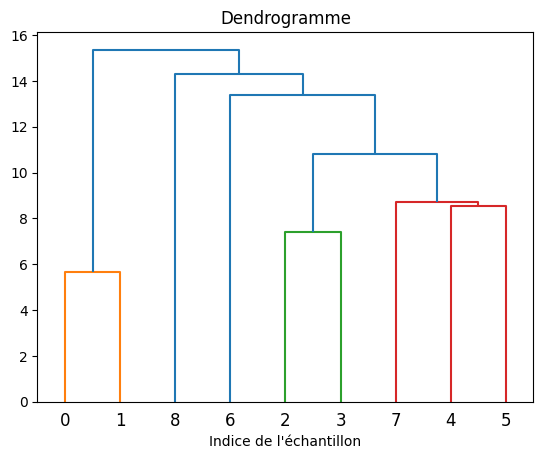

In [432]:
# maintenant, on va utiliser la fonction de scipy pour comparer les résultats
linkage_matrix = linkage(S, 'single') # Elle est composé de N-1 lignes et 4 colonnes (i, j, d, n) avec i et j les indices des clusters fusionnés, d la distance entre les clusters et n le nombre d'éléments dans le cluster
dendrogram(linkage_matrix, orientation='top')
plt.title('Dendrogramme')
plt.xlabel('Indice de l\'échantillon')
plt.show()

# Remarque :
### On remarque que le dendrogramme de la fonction de scipy est similaire (à l'ordre des indices de l'axe X pres) à notre implémentation de l'algorithme de clustering hiérarchique agglomératif. Donc notre implémentation est correcte.

# Conclusion sur la complexité des deux algorithmes :
### Notre implémentation de l'algorithme de clustering hiérarchique agglomératif est correcte, le premier est en O(N³) et le deuxième est en O(N²). On remarque que le deuxieme est plus rapide que le premier.